# Oracle-MNIST: Data Awareness Notebook

This notebook explores the **Oracle-MNIST** dataset:
- Inspect the dataset structure (train/test sizes, shapes, labels).
- Compute pixel statistics (min, max, mean, std, histogram).
- Visual sanity check with random and per-class grids.
- Optional deeper views: contrast/windowing, sparsity, rebinning, zoomed patches, class mean/std images.

Goal: **understand the nature of the data** before modeling.


In [1]:
import gzip, struct, numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# Loader for IDX format (Oracle-MNIST is packaged like MNIST)
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(shape)

# Update to your local path
base_path = './data/oracle'

images_train = read_idx(f'{base_path}/train-images-idx3-ubyte.gz')
labels_train = read_idx(f'{base_path}/train-labels-idx1-ubyte.gz')
images_test  = read_idx(f'{base_path}/t10k-images-idx3-ubyte.gz')
labels_test  = read_idx(f'{base_path}/t10k-labels-idx1-ubyte.gz')

print("Train:", images_train.shape, labels_train.shape)
print("Test :", images_test.shape, labels_test.shape)


Train: (27222, 28, 28) (27222,)
Test : (3000, 28, 28) (3000,)


## First Look at the Dataset

Let’s check:
- Train/test sizes
- Shape of each image
- A grid of the **first samples** as provided


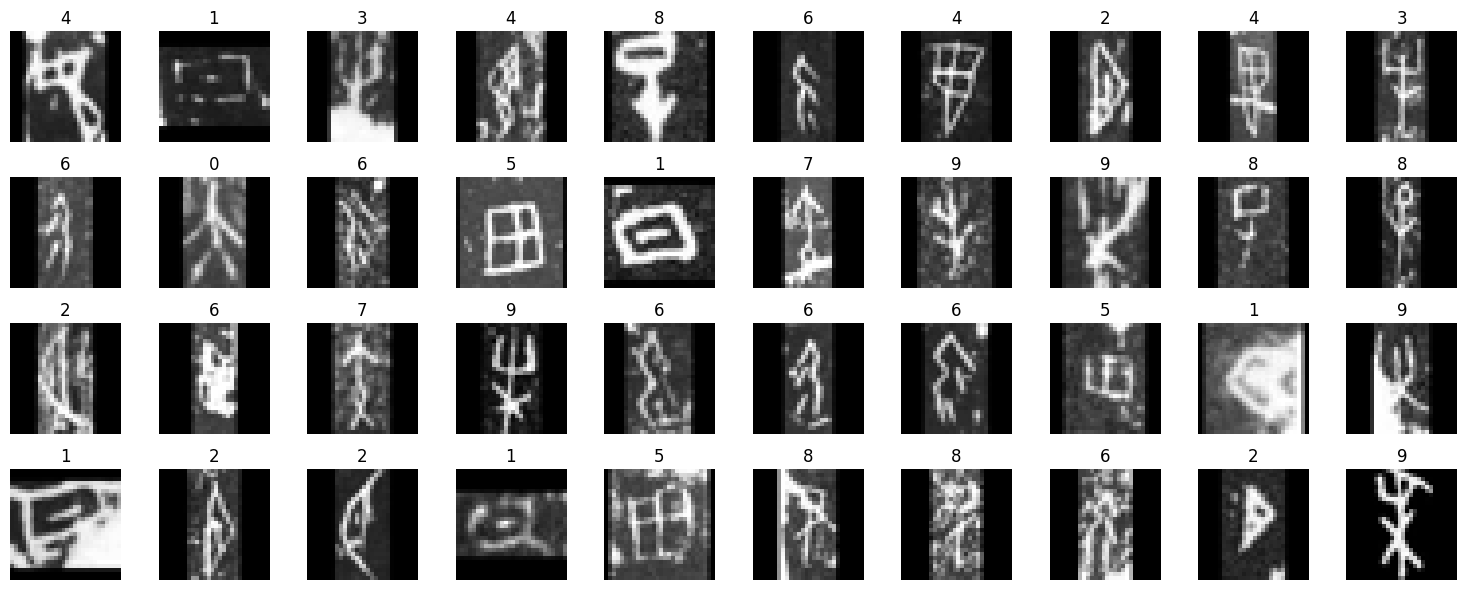

In [2]:
def grid(images, labels=None, cols=10, size=1.5):
    n = len(images)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(cols*size, rows*size))
    for i,(img,lbl) in enumerate(zip(images, labels if labels is not None else [None]*n)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        if lbl is not None:
            plt.title(str(lbl))
    plt.tight_layout()
    plt.show()

# Show first 40 raw training images
idxs = np.arange(40)
grid([images_train[i] for i in idxs], [labels_train[i] for i in idxs])


## Dataset Summary

We check:
- Class balance (number of samples per label).
- Pixel value statistics (range, mean, std, percentiles).
- Pixel histogram (are values mostly 0 and 255, or spread?).


Label distribution (train): Counter({9: 3399, 8: 3335, 1: 2765, 6: 2710, 2: 2668, 3: 2614, 4: 2610, 0: 2433, 7: 2360, 5: 2328})
Pixel min/max: 0.0 255.0
Mean/std: 59.67572 72.396255
p1: 0.00
p5: 0.00
p25: 0.00
p50: 37.00
p75: 91.00
p95: 225.00
p99: 254.00


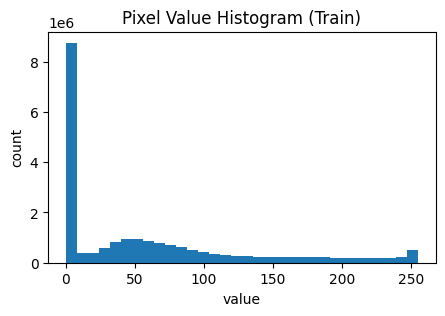

In [3]:
# Label distribution
counts = Counter(labels_train.tolist())
print("Label distribution (train):", counts)

# Pixel statistics
vals = images_train.reshape(-1).astype(np.float32)
print("Pixel min/max:", vals.min(), vals.max())
print("Mean/std:", vals.mean(), vals.std())
for q in [1,5,25,50,75,95,99]:
    print(f"p{q}: {np.percentile(vals,q):.2f}")

plt.figure(figsize=(5,3))
plt.hist(vals, bins=32)
plt.title("Pixel Value Histogram (Train)")
plt.xlabel("value"); plt.ylabel("count")
plt.show()


## Visual Sanity Checks

- **Random grid**: ensures images look correct and labels match.
- **Per-class grid**: see diversity within each class.


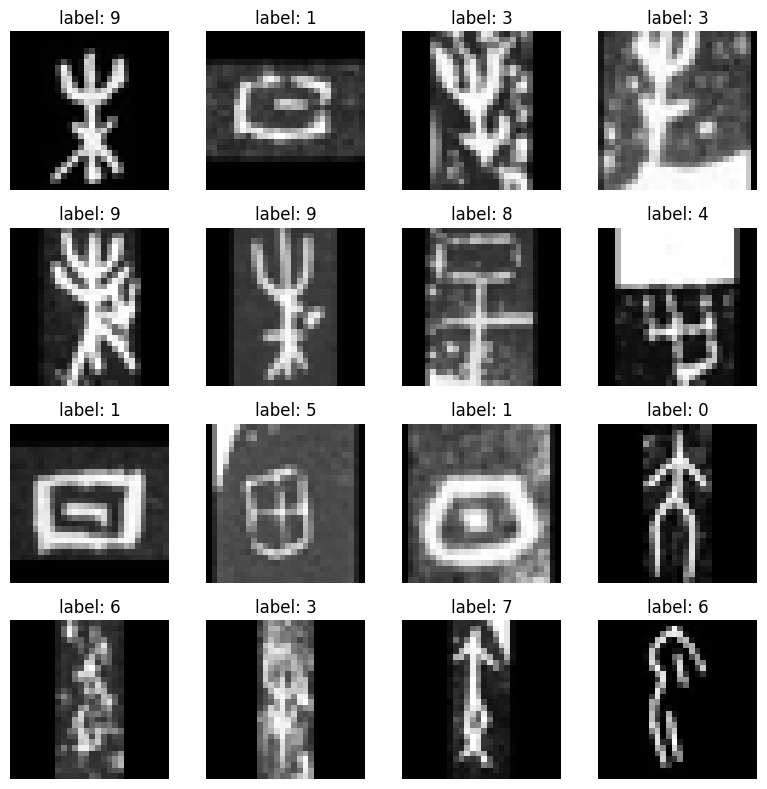

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose:
# images_train is a numpy array of shape (N_train, H, W) or (N_train, H, W, C)
# labels_train is a 1D array of length N_train

def show_images(images, labels, num_images=20, cmap='gray'):
    """
    Show a grid of num_images from images with their labels.
    """
    # Choose num_images random indices
    N = images.shape[0]
    indices = np.random.choice(N, size=num_images, replace=False)
    
    # Determine grid size
    cols = int(np.sqrt(num_images))
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    for ax, idx in zip(axes, indices):
        img = images[idx]
        lbl = labels[idx]
        # if there's a channel dimension, e.g. (H, W, 3) or (...,1), you may need to squeeze or select
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[...,0]
        ax.imshow(img, cmap=cmap)
        ax.set_title(f'label: {lbl}')
        ax.axis('off')
    
    # If more subplots than images, hide extras
    for ax in axes[len(indices):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage:
show_images(images_train, labels_train, num_images=16)


## Optional: Deeper Insights

These are not essential for modeling, but good for **understanding data nature**:
- Windowing / contrast adjustment
- Sparsity / density of strokes
- Rebinning (downsampling)
- Zoom into patches
- Per-class mean and std images


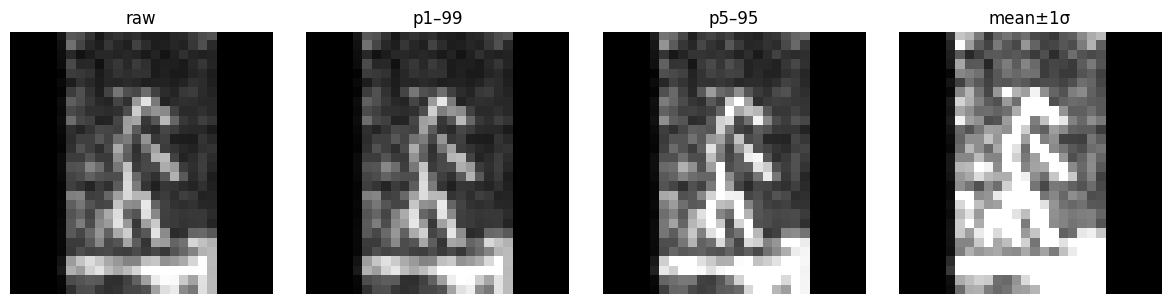

In [5]:
def window_linear(arr, vmin=None, vmax=None, pmin=None, pmax=None):
    a = arr.astype(np.float32)
    if pmin is not None or pmax is not None:
        if pmin is None: pmin = 0
        if pmax is None: pmax = 100
        vmin = np.percentile(a, pmin) if vmin is None else vmin
        vmax = np.percentile(a, pmax) if vmax is None else vmax
    if vmin is None: vmin = a.min()
    if vmax is None: vmax = a.max()
    return np.clip((a-vmin)/(vmax-vmin+1e-9),0,1)

i = random.randint(0, images_train.shape[0]-1)
arr = images_train[i]

im_a = window_linear(arr, pmin=1, pmax=99)
im_b = window_linear(arr, pmin=5, pmax=95)
mu, sd = arr.mean(), arr.std()
im_c = window_linear(arr, vmin=mu-sd, vmax=mu+sd)

grid([arr, im_a, im_b, im_c], ["raw","p1–99","p5–95","mean±1σ"], cols=4, size=3)


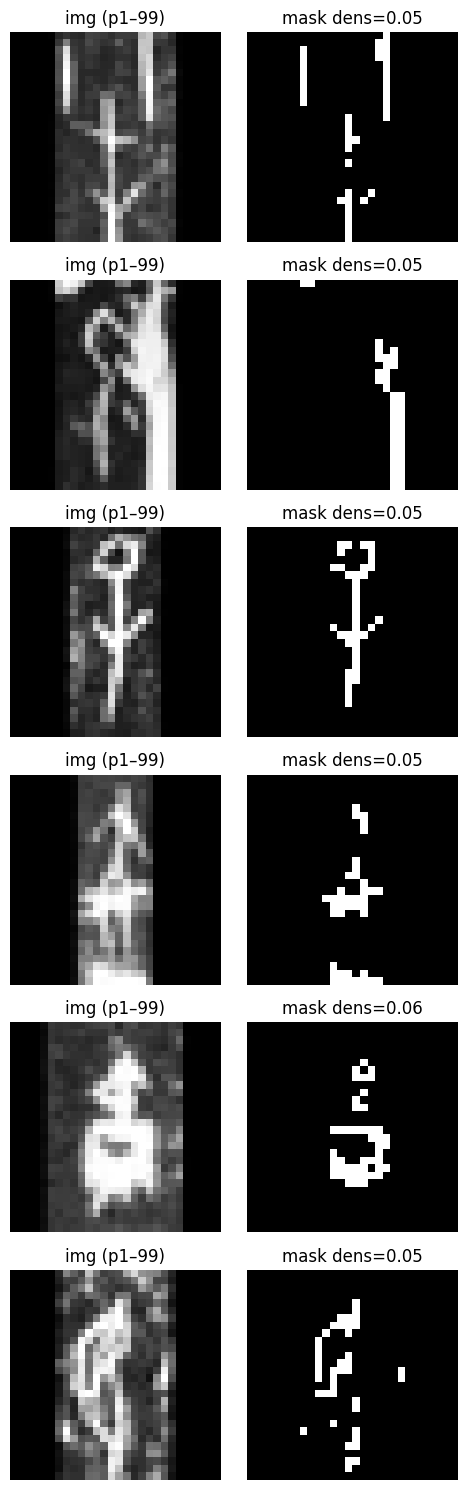

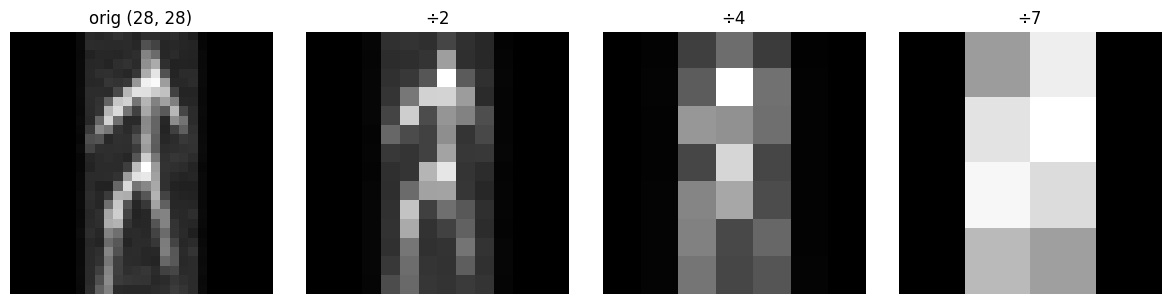

In [6]:
def sparsity_metrics(arr, p=95):
    thr = np.percentile(arr, p)
    mask = (arr >= thr)
    return thr, mask.mean(), mask

idxs = np.random.choice(images_train.shape[0], 6, replace=False)
ims, titles = [], []
for j in idxs:
    arr = images_train[j]
    thr, dens, mask = sparsity_metrics(arr, p=95)
    ims += [window_linear(arr, pmin=1, pmax=99), mask.astype(float)]
    titles += [f"img (p1–99)", f"mask dens={dens:.2f}"]
grid(ims, titles, cols=2, size=2.5)

def block_reduce_mean(arr, by=2):
    H, W = arr.shape
    h = (H//by)*by; w = (W//by)*by
    return arr[:h,:w].reshape(h//by,by,w//by,by).mean(axis=(1,3))

i = random.randint(0, images_train.shape[0]-1)
arr = images_train[i]
ims = [arr, block_reduce_mean(arr,2), block_reduce_mean(arr,4), block_reduce_mean(arr,7)]
titles = [f"orig {arr.shape}","÷2","÷4","÷7"]
grid(ims, titles, cols=4, size=3)


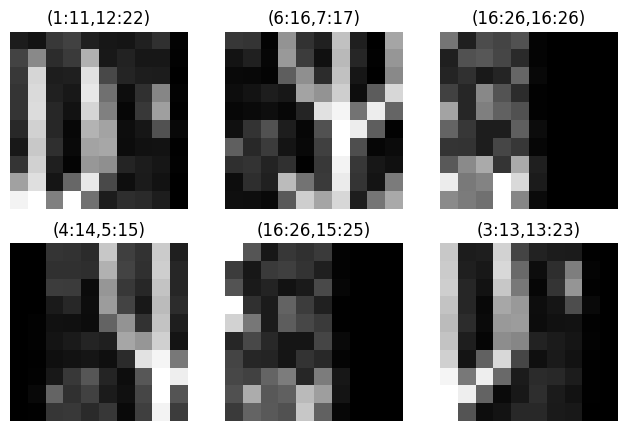

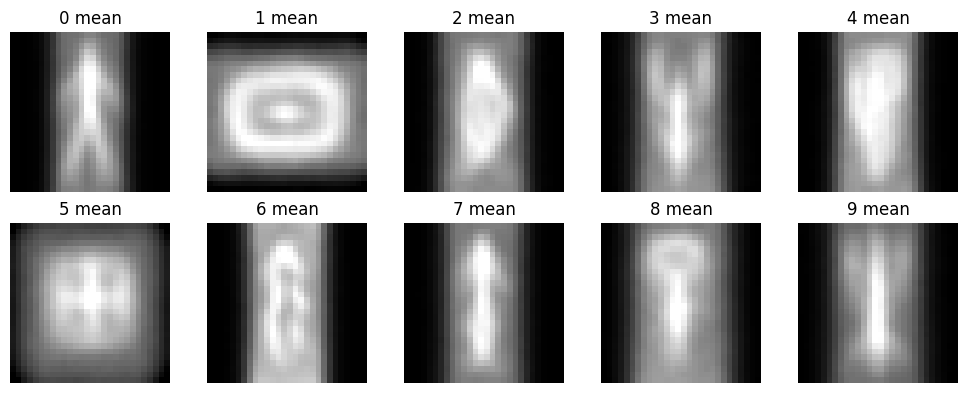

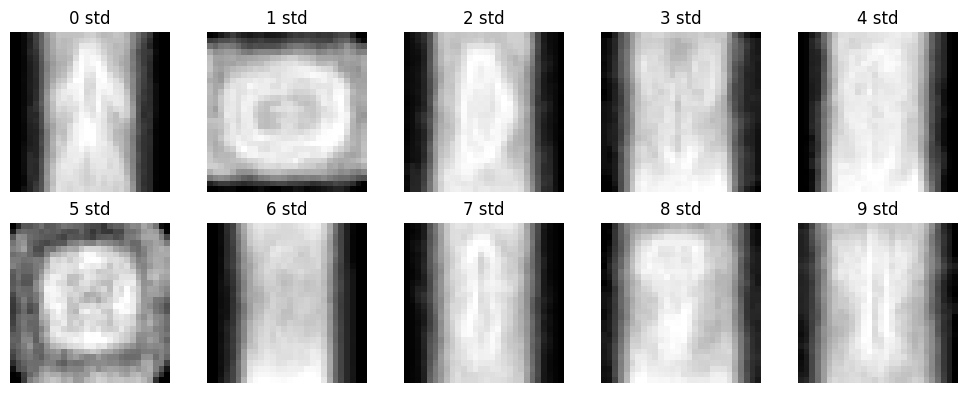

In [7]:
def show_random_windows(arr, k=6, win=(10,10)):
    H,W = arr.shape; h,w = win
    ims,titles=[],[]
    for _ in range(k):
        y0 = np.random.randint(0,H-h+1)
        x0 = np.random.randint(0,W-w+1)
        patch = arr[y0:y0+h, x0:x0+w]
        ims.append(window_linear(patch, pmin=1, pmax=99))
        titles.append(f"({y0}:{y0+h},{x0}:{x0+w})")
    grid(ims,titles,cols=3,size=2.2)

show_random_windows(images_train[random.randint(0, images_train.shape[0]-1)], k=6, win=(10,10))

# Per-class mean/std
means,stds,lbls=[],[],[]
for lbl in sorted(set(labels_train.tolist())):
    idx = np.where(labels_train==lbl)[0][:500]
    stack = images_train[idx].astype(np.float32)
    means.append(stack.mean(axis=0))
    stds.append(stack.std(axis=0))
    lbls.append(lbl)

grid([window_linear(m,pmin=1,pmax=99) for m in means],
     [f"{l} mean" for l in lbls], cols=5, size=2.0)
grid([window_linear(s,pmin=1,pmax=99) for s in stds],
     [f"{l} std" for l in lbls], cols=5, size=2.0)


## Takeaways

- The dataset comes already split into **train/test**.
- Images are 28×28 grayscale, pixel values 0–255.
- Labels are balanced across classes.
- Simple inspection confirms clean, legible samples.
- Windowing/rebinning/zoom show how structure survives at different scales.
- Per-class means reveal “prototype” characters, std highlights variation.

**→ Ready for preprocessing & modeling.**
